# [Essais de modélisation](Section)

Dans ce notebook, nous realisaons une modélisation à l'aide d'un algorithme de clustering, à savoir K-Means basé sur l'analyse RFM (Récence, Fréquence et Monétaire) pour la segmentation de la clientèle.

In [226]:
import os
import glob
import datetime
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
from math import pi
import plotly.graph_objects as go


from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999

In [227]:
#repeater_data = pd.read_csv('data/repeater_data.csv')
#repeater_data.drop("Unnamed: 0", axis=1, inplace=True)

#first_timer_data = pd.read_csv('data/first_timer_data.csv')
#first_timer_data.drop("Unnamed: 0", axis=1, inplace=True)

feat_eng_full = pd.read_csv('data/feat_engine_full_df.csv')
                # , sep='\t', encoding='utf-8')
feat_eng_full.drop("Unnamed: 0", axis=1, inplace=True)
#feat_eng_full.drop('index', axis=1, inplace=True)

## [Segmentation RFM](Section)

- Nous sommes commençons notre segmentation de marché avec la segementation RFM. La méthode de segmentation RFM permet un classement des clients en fonction de leurs habitudes d'achat. On peut ainsi optimiser une stratégie marketing en fonction de nos clients. Le classement RFM se fait en fonction de 3 critères : Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.


- Récence indique la date du dernier achat. Il s'agit du nombre de jours depuis la dernière commande d'un client.
- Fréquence est le nombre d'achat sur une période déterminé. Cela peut être 3 mois, 6 mois ou un 1 an. Elle indique la fidélité d'un client, plus sa valeur est élevé et plus le client est engagé.
- Montant est la somme totale qu'un client dépense sur une période donnée

La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque. 

Les données RFM restent des données très utilisées, mais une "simple" segmentation RFM est de plus en plus rare. C'est la raison pour laquelle derrière nous ferons du clustering en utilisant la méthode de k-means.

In [333]:
feat_eng_full.columns

Index(['customer_unique_id', 'seller_zip_code_prefix', 'product_category_name',
       'product_category_name.1', 'product_category_name.2',
       'product_category_name.3', 'review_score', 'payment_value',
       'payment_installments', 'payment_type', 'order_estimated_delivery_date',
       'seller_state', 'order_item_id', 'order_purchase_timestamp', 'price',
       'seller_id', 'product_id', 'order_id', 'customer_state',
       'customer_city', 'customer_zip_code_prefix', 'payment_sequential',
       'product_weight_g', 'order_delivered_customer_date', 'year_of_purchase',
       'month_of_purchase', 'date_of_purchase', 'time_of_purchase',
       'days_to_delivery', 'estimated_days_to_delivery', 'days_early_late',
       'seller_avg_rating'],
      dtype='object')

In [228]:
feat_eng_full.rename(columns={"order_purchase_timestamp": "purchase_time"},
              inplace=True)

feat_eng_full["purchase_time"] = feat_eng_full["purchase_time"].astype('datetime64[ns]')

In [229]:
feat_eng_full=feat_eng_full[['customer_unique_id', 'seller_zip_code_prefix', 'product_category_name',
                             'review_score', 'payment_value', 'payment_installments', 'payment_type',
                             'purchase_time', 'price', 'seller_id', 'seller_state',
                             'product_id', 'order_id', 'customer_state', 'customer_city',
                             'customer_zip_code_prefix', 'payment_sequential', 'order_item_id',
                             'order_delivered_customer_date', 'days_to_delivery',
                             'estimated_days_to_delivery', 'days_early_late', 'seller_avg_rating']]
#'repeater', 

Calcul des valeurs R, F et M de la segmentation RFM. La cellule suivante retourne un dataframe avec les variables 'Recency', 'Frequency' et 'Monetary' qui correspondent aux coefficients R, F et M. 

In [191]:
# Commençons par regarder les dates de début et de fin d'achat.
print('Min : {}, Max : {}'.format(min(feat_eng_full.purchase_time), max(feat_eng_full.purchase_time)))

Min : 2016-10-03 00:00:00, Max : 2018-08-29 00:00:00


In [230]:
pin_date = max(feat_eng_full.purchase_time) + dt.timedelta(1)

# Création d'un datafarme RFM
rfm = feat_eng_full.groupby('customer_unique_id').agg({
    'purchase_time' : lambda x: (pin_date - x.max()).days,
    'order_item_id' : 'count', 
    'payment_value' : 'sum'})

# Rénommage des colonnes 
rfm.rename(columns = {'purchase_time' : 'Recency', 
                      'order_item_id' : 'Frequency', 
                      'payment_value' : 'Monetary'}, inplace = True)

rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,175,24832.50
0000b849f77a49e4a4ce2b2a4ca5be3f,115,42,1141.98
0000f46a3911fa3c0805444483337064,538,72,6207.84
0000f6ccb0745a6a4b88665a16c9f078,322,18,785.16
0004aac84e0df4da2b147fca70cf8255,289,147,28942.83


## [Vérification des Outliers](Section)

In [231]:
# Nous utiliserons l'intervalle interquartile pour gérer les valeurs aberrantes

# Détermination des limites 
def limit(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    # Détermination des limites inférieures et supérieures 
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.5) + (IQR * 3)
    print('Limite inférieure:', lower_limit)
    print('Limite inférieure extreme:', lower_limit_extreme)
    print('Limite supérieur :', upper_limit)
    print('Limite supérieure extreme:', upper_limit_extreme)

#Calcul des valeurs aberrantes en pourcentage    
def percent_outliers(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    #Détermination des limites inférieure et supérieure
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.95) + (IQR * 3)
    #Pourcentage de valeurs aberrantes par rapport aux données totales
    print('Limite inférieure: {} %'.format(rfm[(rfm[i] >= lower_limit)].shape[0]/ rfm.shape[0]*100))
    print('Limite inférieure extreme: {} %'.format(rfm[(rfm[i] >= lower_limit_extreme)].shape[0]/rfm.shape[0]*100))
    print('Limite supérieur: {} %'.format(rfm[(rfm[i] >= upper_limit)].shape[0]/ rfm.shape[0]*100))
    print('Limite supérieure extreme: {} %'.format(rfm[(rfm[i] >= upper_limit_extreme)].shape[0]/rfm.shape[0]*100))

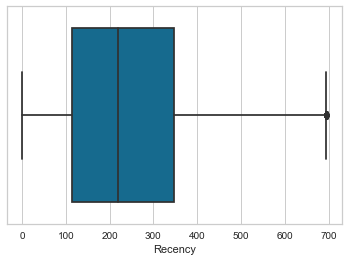

In [232]:
# Les valeurs aberrantes dans la colonne "Recency"
sns.boxplot(x=rfm["Recency"])

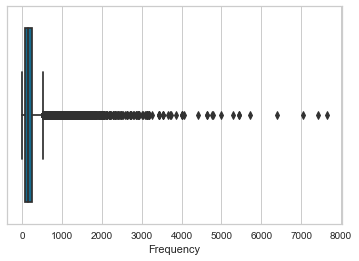

In [233]:
# Regardons les ouliers dans la colonne "Frequency"
sns.boxplot(x=rfm["Frequency"])

Les valeurs aberrantes ne sont pas supprimées de la colonne "Frequency", car les valeurs aberrantes sont surément issues des multiples transactions entre 2016-2018, puisque nous avons vu plus que nos données sont entres 2016 et 2018.  

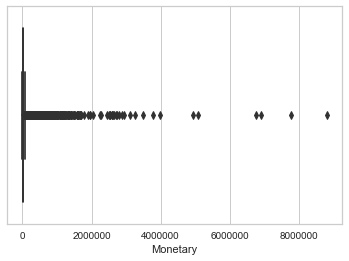

In [234]:
# Regardons les ouliers dans la colonne "Monetary"
sns.boxplot(x=rfm["Monetary"])

In [235]:
print(limit('Monetary'))
print('-'*50)
print(percent_outliers('Monetary'))

Limite inférieure: -123071.47775000051
Limite inférieure extreme: -258797.10050000105
Limite supérieur : 238863.51625000092
Limite supérieure extreme: 284105.3905000011
None
--------------------------------------------------
Limite inférieure: 100.0 %
Limite inférieure extreme: 100.0 %
Limite supérieur: 1.3650613951058086 %
Limite supérieure extreme: 0.611773926674214 %
None


In [236]:
# Suppression des valeurs aberrantes dans les colonnes 'Monetary' 
# Supérieures à 1500 car elles sont en dehors de la limite maximale 
#de 95% de la distribution des données
outliers1_drop = rfm[(rfm['Monetary'] > 1500)].index
rfm.drop(outliers1_drop, inplace=True)

## [RFM Percentile](Section)

Nous précedons à une division des clients en trois groupes en se basant sur "Recency", "Frequency" et "Monetary". 

In [237]:
# Créons des groupes de clients en fonction de la "Recency", de la "Frequency" et de la valeur "Monetary"
# Recency: moins il y a de jours, mieux c'est. 

r_labels = range(3, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 3, labels = r_labels).astype('int')

f_groups = pd.qcut(rfm.Frequency.rank(method='first'), 3).astype('str')
#rfm['F'] = np.where((rfm['Frequency'] != 1) & (rfm['Frequency'] != 2), 3, rfm.Frequency)

m_labels = range(1, 4)
m_groups = pd.qcut(rfm.Monetary, q = 3, labels = m_labels).astype('int')

In [238]:
# Création de colonnes basées sur le groupe qui a été créé
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [239]:
rfm['F'].value_counts()

(0.999, 2206.333]       2206
(4411.667, 6617.0]      2206
(2206.333, 4411.667]    2205
Name: F, dtype: int64

In [240]:
# Changeons la colonne d'entrée F en catégorielle
rfm['F'] = rfm['F'].replace({'(0.999, 2206.333]' : 1,
                             '(4411.667, 6617.0]' : 2,
                             '(2206.333, 4411.667]' : 3}).astype('int')

In [241]:
# Combinons ces trois colonnes
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,115,42,1141.98,3,2,3,3.02.03.0,8
0000f6ccb0745a6a4b88665a16c9f078,322,18,785.16,1,1,2,1.01.02.0,4
00050ab1314c0e55a6ca13cf7181fecf,132,27,955.26,3,3,2,3.03.02.0,8
000d460961d6dbfa3ec6c9f5805769e1,235,18,660.24,2,1,1,2.01.01.0,4
00196fdb2bf9edfc35e88ebfbcf8d781,189,27,729.00,2,3,1,2.03.01.0,6


In [242]:
# Créons des étiquettes basées sur RFM_Score
score_labels = ['Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q=3, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_unique_id,,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,115,42,1141.98,3,2,3,3.02.03.0,8,Gold
0000f6ccb0745a6a4b88665a16c9f078,322,18,785.16,1,1,2,1.01.02.0,4,Bronze
00050ab1314c0e55a6ca13cf7181fecf,132,27,955.26,3,3,2,3.03.02.0,8,Gold
000d460961d6dbfa3ec6c9f5805769e1,235,18,660.24,2,1,1,2.01.01.0,4,Bronze
00196fdb2bf9edfc35e88ebfbcf8d781,189,27,729.00,2,3,1,2.03.01.0,6,Silver


## [Gestion de l'asymétrie et de la mise à l'échelle](Section)

Pour les données qui seront incluses dans l'algorithme K-Means, une distribution normale sera utilisée pour faciliter la formation des clusters.

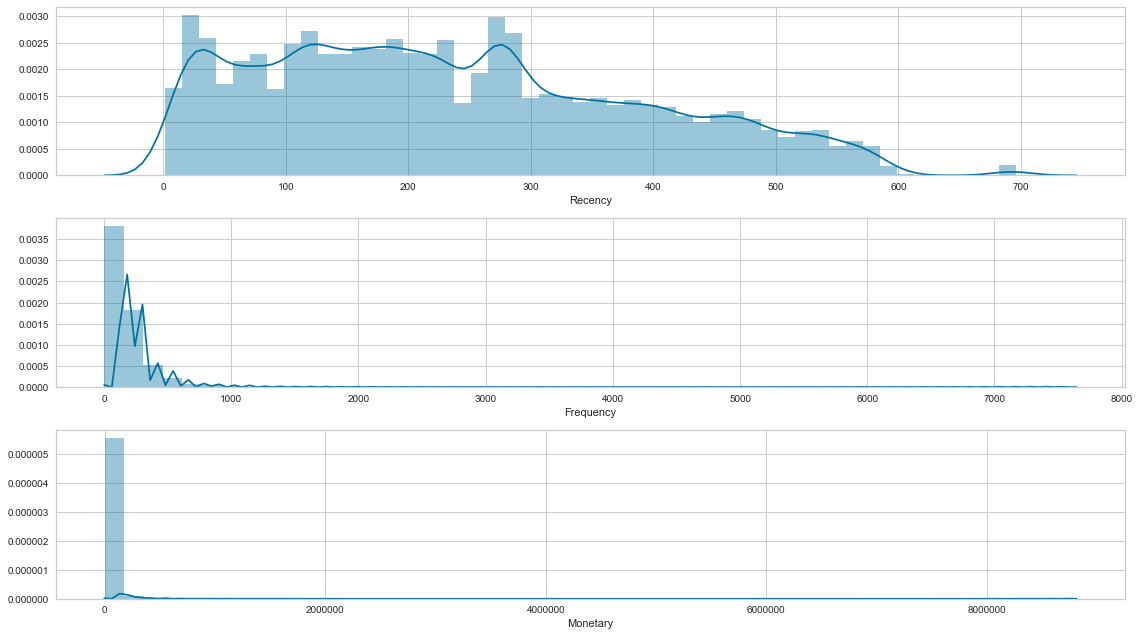

In [249]:
#Visualisons la valeur RFM
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'], kde_kws={'bw': 0.1}, label='Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

In [243]:
# Rendre la distribution des données normale
from scipy import stats

rfm_log = rfm[['Recency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log['Frequency'] = stats.boxcox(rfm['Frequency'])[0]
rfm_log.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,4.745,7.041,12.310743
0000f6ccb0745a6a4b88665a16c9f078,5.775,6.666,7.063287
00050ab1314c0e55a6ca13cf7181fecf,4.883,6.862,9.273018
000d460961d6dbfa3ec6c9f5805769e1,5.460,6.493,7.063287
00196fdb2bf9edfc35e88ebfbcf8d781,5.242,6.592,9.273018


In [244]:
# Retourne toutes les données de la même taille en les mettant à l'échelle

scaler = StandardScaler()
minmax = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [245]:
# Créons un nouveau dataframe après la mise à l'échelle
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.412239,0.590167,1.207419
0000f6ccb0745a6a4b88665a16c9f078,0.716663,-0.042966,-0.325144
00050ab1314c0e55a6ca13cf7181fecf,-0.260988,0.287952,0.320227
000d460961d6dbfa3ec6c9f5805769e1,0.371416,-0.335051,-0.325144
00196fdb2bf9edfc35e88ebfbcf8d781,0.132484,-0.167904,0.320227


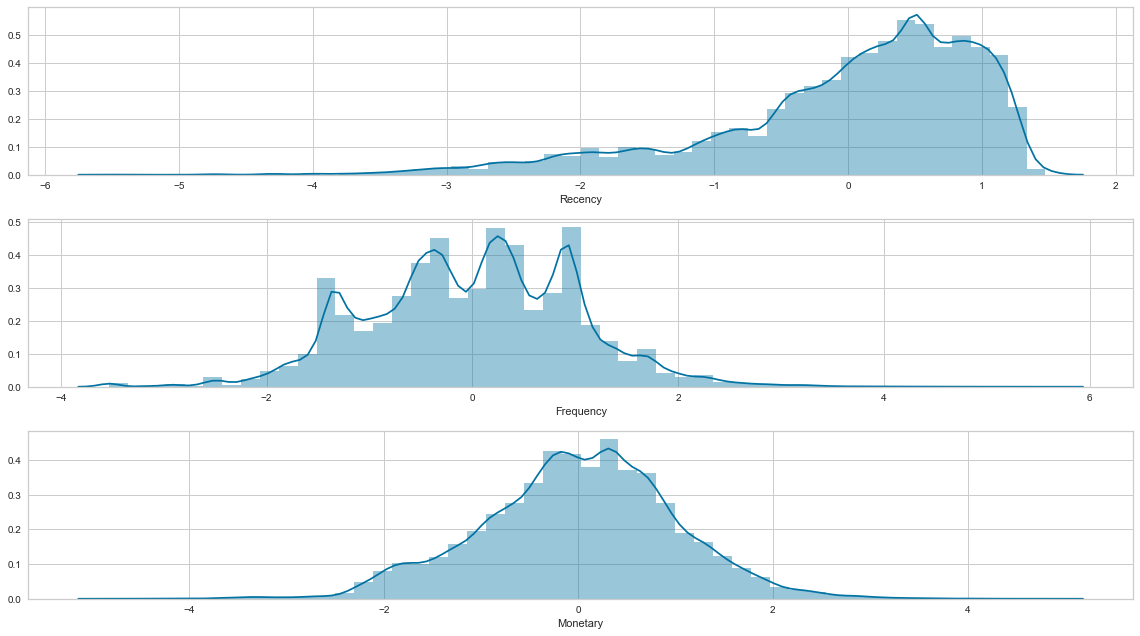

In [253]:
# Visualisons à nouveau RFM après la transformation du journal et la mise à l'échelle
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency, kde_kws={'bw': 0.1}, label='Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

## [K-Means Clustering](Section)

Ici, le clustering sera effectué à l'aide de l'algorithme K-Means pour obtenir le cluster optimal de données RFM

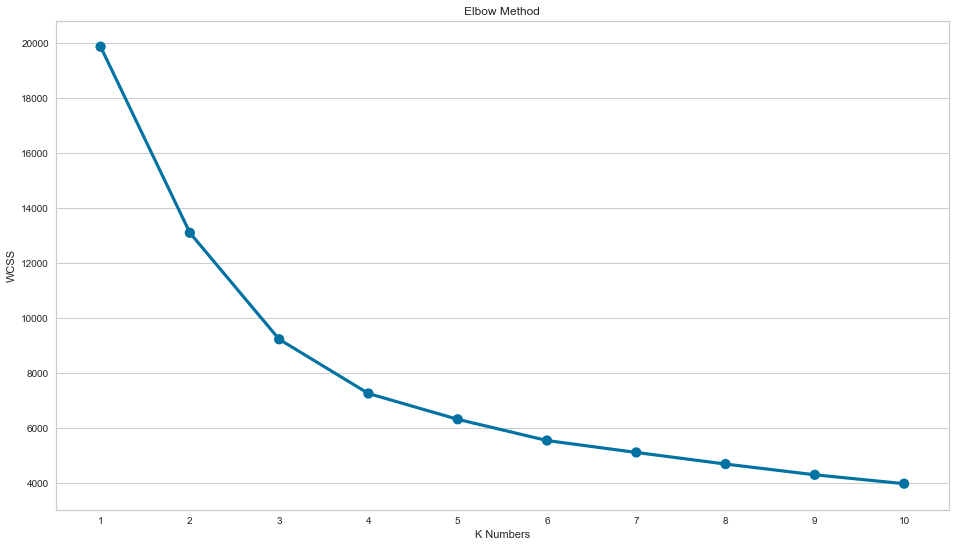

In [246]:
# Trouver le point optimal du cluster avec la méthode des ELbow
wcss = {}

for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_
    
# Visualisation de la méthode des Elbow
fig, ax = plt.subplots(figsize=(16, 9))
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()


In [247]:
# Selection de n_clusters = 4 selon la méthode des Elbow
clus = KMeans(n_clusters= 2, n_init=10, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [248]:
# Transfére des résultats du cluster vers les données RFM initiales
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,115,42,1141.98,3,2,3,3.02.03.0,8,Gold,0
0000f6ccb0745a6a4b88665a16c9f078,322,18,785.16,1,1,2,1.01.02.0,4,Bronze,0
00050ab1314c0e55a6ca13cf7181fecf,132,27,955.26,3,3,2,3.03.02.0,8,Gold,0
000d460961d6dbfa3ec6c9f5805769e1,235,18,660.24,2,1,1,2.01.01.0,4,Bronze,0
00196fdb2bf9edfc35e88ebfbcf8d781,189,27,729.00,2,3,1,2.03.01.0,6,Silver,0


## [Evaluation](Section)

Après avoir créé un modèle à l'aide de KMeans, nous allons maintenant évaluer le modèle et voir si les clusters crées sont vraiment différents de chaque cluster à l'aide de l'analyse de silhouuette. 

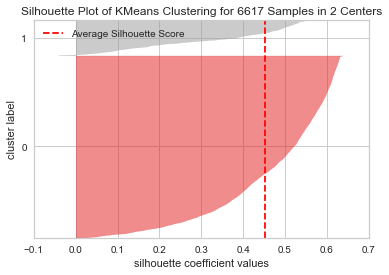

In [249]:
# Visualisation de l'analyse de silhouette
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(clus)

visualizer.fit(rfm_scaled) 
visualizer.poof() 

In [250]:
dataset = rfm_scaled[["Monetary","Frequency"]]

In [251]:
# Nombres des clusters
K=3

# Selection aléatoire du centre des 
# clusters
Centroids = (dataset.sample(n=K))

In [252]:
diff = 1
j=0

while(diff!=0):
    XD=dataset
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["Monetary"]-row_d["Monetary"])**2
            d2=(row_c["Frequency"]-row_d["Frequency"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        dataset[i]=ED
        i=i+1

    C=[]
    for index,row in dataset.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    dataset["Cluster"]=C
    Centroids_new = dataset.groupby(["Cluster"]).mean()[["Frequency","Monetary"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['Frequency'] - Centroids['Frequency']).sum() + (Centroids_new['Monetary'] - Centroids['Monetary']).sum()
        print(diff.sum())
    Centroids = dataset.groupby(["Cluster"]).mean()[["Frequency","Monetary"]]

0.20521727579737742
0.029315105365054397
0.0050448811495279605
0.0010854990695679245
0.0019143480325604506
0.0


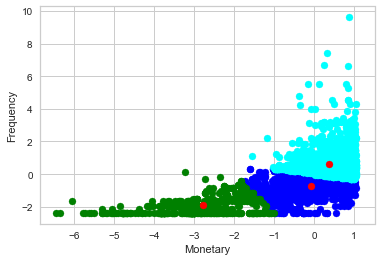

In [253]:
color=['blue','green','cyan']
for k in range(K):
    data=dataset[dataset["Cluster"]==k+1]
    plt.scatter(data["Monetary"],data["Frequency"],c=color[k])
plt.scatter(Centroids["Monetary"],Centroids["Frequency"],c='red')
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.show()

## [Visualisation](Section)

Nous allons visualiser pour faciliter la compréhension des clusters que nous avons crée avec l'algorithme KMeans. Nous utiliserons le «Snake Plot», très utilisé dans le monde du marketing pour voir quelles catégories de clients  appartiennent à chaque clusters.

In [254]:
# Utilisons les données standardisées
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,customer_unique_id,Recency,Monetary,Frequency,K_Cluster,RFM_Level
0,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.412239,0.590167,1.207419,0,Gold
1,0000f6ccb0745a6a4b88665a16c9f078,0.716663,-0.042966,-0.325144,0,Bronze
2,00050ab1314c0e55a6ca13cf7181fecf,-0.260988,0.287952,0.320227,0,Gold
3,000d460961d6dbfa3ec6c9f5805769e1,0.371416,-0.335051,-0.325144,0,Bronze
4,00196fdb2bf9edfc35e88ebfbcf8d781,0.132484,-0.167904,0.320227,0,Silver


In [255]:
# fusion du bloc de données qui a été créé
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['customer_unique_id', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,customer_unique_id,RFM_Level,K_Cluster,Metrics,Value
0,0000b849f77a49e4a4ce2b2a4ca5be3f,Gold,0,Recency,-0.412239
1,0000f6ccb0745a6a4b88665a16c9f078,Bronze,0,Recency,0.716663
2,00050ab1314c0e55a6ca13cf7181fecf,Gold,0,Recency,-0.260988
3,000d460961d6dbfa3ec6c9f5805769e1,Bronze,0,Recency,0.371416
4,00196fdb2bf9edfc35e88ebfbcf8d781,Silver,0,Recency,0.132484


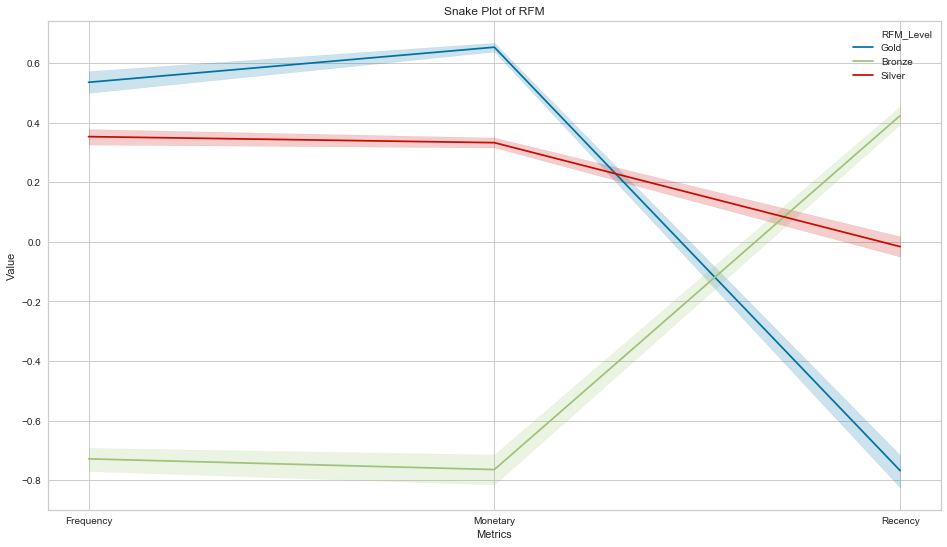

In [256]:
# visualisation snake plot
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot pour RFM')
plt.legend(loc = 'upper right')

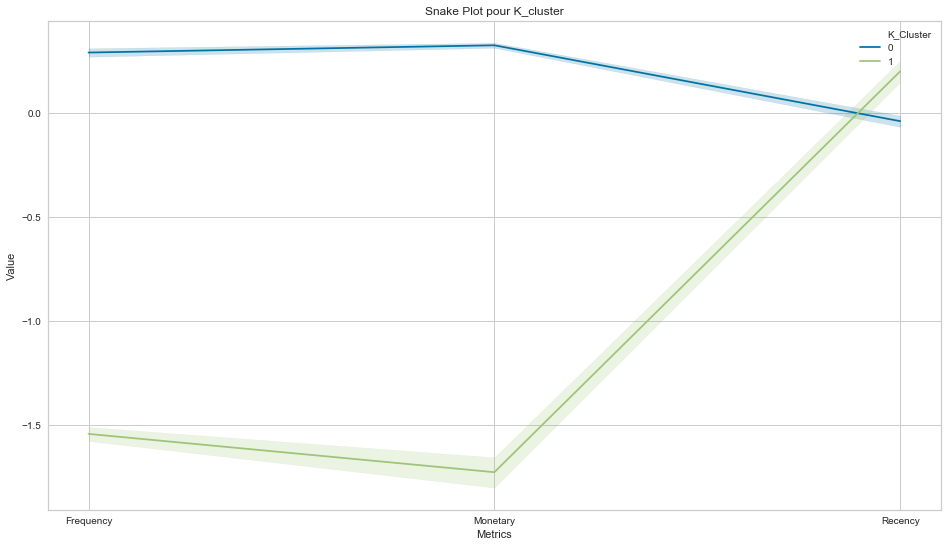

In [258]:
# Visualisation des tracés du snake plot avec K-Means
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot pour K_cluster')
plt.legend(loc = 'upper right')

Comme nous pouvons le voir dans les deux graphiques ci-dessus, nous pouvons conclure pour chaque cluster:

- Bronze : La fréquence n'est pas trop élevée par rapport à la transaction nominale, mais la dernière fois qu'il a acheté est très recent, d'où cette pente rapide. 

- Silver : La fréquence des achats est assez élevée et la transaction nominale est assez élevée, mais la dernière fois qu'il a acheté n'est pas très recent, d'où cette pente.

- Gold : la fréquence des achats est élevée et le montant nominal dépensé est également élevé, mais l'intervalle de temps avec la dernière transaction est long.

Text(0, 0.5, 'Nombre de Customer')

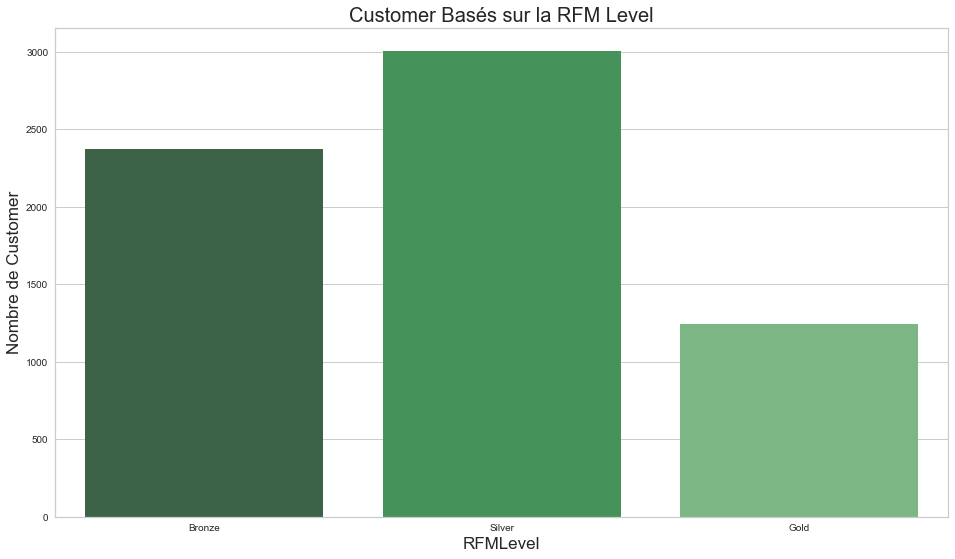

In [259]:
# Combien de clients y a-t-il par catégorie?
rfm_cus_level = rfm_scaled.groupby('RFM_Level')['customer_unique_id'].nunique().reset_index()

# Visualisation
fig=plt.figure(figsize=(16,9))
sns.barplot(y=rfm_cus_level['customer_unique_id'], x=rfm_cus_level['RFM_Level'], palette="Greens_d")
plt.title('Customer Basés sur la RFM Level',fontsize=20)
plt.xlabel('RFMLevel',fontsize=17)
plt.ylabel('Nombre de Customer',fontsize=17)

## [DBSCAN CLUSTERING](Section)

Estimation du nombres de clusters: 3
Estimation du nombres de points de bruits: 22
Homogeneity: 0.947
Completeness: 0.868
V-measure: 0.906
Adjusted Rand Index: 0.943
Adjusted Mutual Information: 0.905
Silhouette Coefficient: 0.621


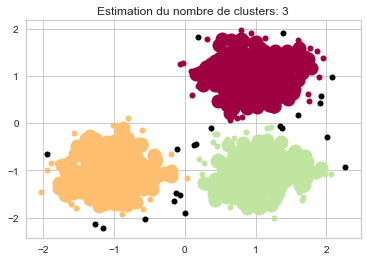

In [267]:
# Generation des données
# d'exemple
centers = [[1, 1], [-1, -1], [1, -1]]
dataset, labels_true = make_blobs(n_samples=750,
                                  centers=centers, cluster_std=0.4,
                                  random_state=0)
# dataset = StandardScaler().fit_transform(dataset)

# Implémentation DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Nombres de clusters dans labels, suppression des bruits si presents.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimation du nombres de clusters: %d' % n_clusters_)
print('Estimation du nombres de points de bruits: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
% metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
% metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
% metrics.silhouette_score(dataset, labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        
    class_member_mask = (labels == k)
    
    xy = dataset[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    
    xy = dataset[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
plt.title('Estimation du nombre de clusters: %d' % n_clusters_)
plt.show()

Nombre de clusters: 2
Homogeneity: 1.0
Completeness: 0.9591493437463376
V-measure: 0.906
Adjusted Rand Index: 0.943
Adjusted Mutual Information: 0.905
Silhouette Coefficient: -0.092


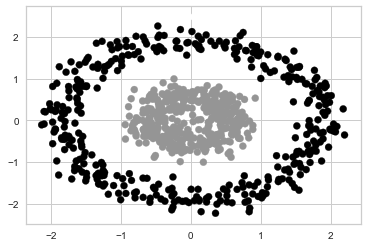

In [268]:
dataset, y = make_circles(n_samples=750, factor=0.3, noise=0.1)
dataset = StandardScaler().fit_transform(dataset)
y_pred = DBSCAN(eps=0.3, min_samples=10).fit_predict(dataset)

plt.scatter(dataset[:,0], dataset[:,1], c=y_pred)
print('Nombre de clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))
print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(dataset, labels))

## [CONCLUSION](Section)

Le but de ce projet étant de fournir à l’équipe marketing une description actionable d'une segmentation de sa clientèle avec une logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps. Nous pouvons voici dire à ce niveau d'avance du projet que : 

- Bronze: Un client qui n'effectue pas d'achats fréquents et la transaction nominale est faible mais la dernière fois qu'il a acheté est très recent. Il y a plus 25000 clients de ce type.

    . On peut essayer de donner des remises ou des offres à un prix nominal abordable afin que le taux de  
    conversion augmente dans cette catégorie de clients car le nombre de clients Bronze est assez important. 

- Silver: Un client qui effectue des achats assez souvent et la transaction nominale est assez élevée, mais la dernière fois qu'il a acheté n'est pas très recent. Il y a 30000 clients de ce type.
 
     . On peut essayer de faire une combinaison de remises et de campagnes post-transaction pour augmenter les   
     achats en utilisant des emails personnalisés qui peuvent donner une touche personnelle.
        
- Gold: Les clients qui achètent fréquemment et ont beaucoup de transactions nominales, mais l'intervalle de temps avec la dernière transaction est long. Il y a 15 000 clients de ce type.
    
    . Cette catégorie de client tient souvent compte des campagnes promotionnelles après avoir effectué leurs 
    transactions pour faire à nouveau des achats. On peut offrir des récompenses car ils sont plus susceptibles de 
    faire des transactions et le nominal est élevé.